In [2]:
# 0. Imports & Load dataset

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# For nicer plots in Jupyter
plt.rcParams["figure.figsize"] = (10, 5)

# -------- Load data --------

data = pd.read_excel("data/final/QVI_data.xlsx")

# Quick check
print(data.head())
print(data.columns)


   LYLTY_CARD_NBR       DATE  STORE_NBR  TXN_ID  PROD_NBR  \
0            1000 2018-10-17          1       1         5   
1            1002 2018-09-16          1       2        58   
2            1003 2019-03-07          1       3        52   
3            1003 2019-03-08          1       4       106   
4            1004 2018-11-02          1       5        96   

                                PROD_NAME  PROD_QTY  TOT_SALES  PACK_SIZE  \
0  Natural Chip        Compny SeaSalt175g         2        6.0        175   
1   Red Rock Deli Chikn&Garlic Aioli 150g         1        2.7        150   
2   Grain Waves Sour    Cream&Chives 210G         1        3.6        210   
3  Natural ChipCo      Hony Soy Chckn175g         1        3.0        175   
4          WW Original Stacked Chips 160g         1        1.9        160   

        BRAND              LIFESTAGE PREMIUM_CUSTOMER  
0     NATURAL  YOUNG SINGLES/COUPLES          Premium  
1         RRD  YOUNG SINGLES/COUPLES       Mainstream  
2 

In [3]:
# 1. Create YEARMONTH and monthly metrics


# Ensure DATE is datetime
data['DATE'] = pd.to_datetime(data['DATE'])

# YEARMONTH in yyyymm format (e.g., 201807)
data['YEARMONTH'] = data['DATE'].dt.year * 100 + data['DATE'].dt.month

# Aggregate metrics per store & month
measure_over_time = (
    data
    .groupby(['STORE_NBR', 'YEARMONTH'])
    .agg(
        totSales=('TOT_SALES', 'sum'),
        nCustomers=('LYLTY_CARD_NBR', 'nunique'),
        nTransactions=('TXN_ID', 'nunique'),
        nChips=('PROD_QTY', 'sum')
    )
    .reset_index()
)

# Derived metrics
measure_over_time['nTxnPerCust']   = (
    measure_over_time['nTransactions'] / measure_over_time['nCustomers']
)
measure_over_time['nChipsPerTxn']  = (
    measure_over_time['nChips'] / measure_over_time['nTransactions']
)
measure_over_time['avgPricePerUnit'] = (
    measure_over_time['totSales'] / measure_over_time['nChips']
)

# Optional sort (like [order()] in R)
measure_over_time = measure_over_time.sort_values(['STORE_NBR', 'YEARMONTH'])

measure_over_time.head()


,STORE_NBR,YEARMONTH,totSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,52,62,1.061224,1.192308,3.337097
1,1,201808,176.1,42,43,54,1.023810,1.255814,3.261111
2,1,201809,278.8,59,62,75,1.050847,1.209677,3.717333
3,1,201810,188.1,44,45,58,1.022727,1.288889,3.243103
4,1,201811,192.6,46,47,57,1.021739,1.212766,3.378947


In [4]:
# 2. Pre-trial selection


# Stores with 12 months of data (pre-trial period)
store_counts = measure_over_time.groupby('STORE_NBR')['YEARMONTH'].nunique()
stores_with_full_obs = store_counts[store_counts == 12].index.tolist()

# Pre-trial period: YEARMONTH < 201902 (same as R template)
pre_trial_measures = measure_over_time[
    (measure_over_time['YEARMONTH'] < 201902) &
    (measure_over_time['STORE_NBR'].isin(stores_with_full_obs))
].copy()

pre_trial_measures.head()


,STORE_NBR,YEARMONTH,totSales,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit
0,1,201807,206.9,49,52,62,1.061224,1.192308,3.337097
1,1,201808,176.1,42,43,54,1.023810,1.255814,3.261111
2,1,201809,278.8,59,62,75,1.050847,1.209677,3.717333
3,1,201810,188.1,44,45,58,1.022727,1.288889,3.243103
4,1,201811,192.6,46,47,57,1.021739,1.212766,3.378947


In [5]:
# 3. Helper: calculateCorrelation


def calculate_correlation(input_df, metric_col, store_comparison):
    """
    input_df: DataFrame with columns ['STORE_NBR', 'YEARMONTH', metric_col]
    metric_col: string, name of metric column to correlate on
    store_comparison: trial store number (int)

    Returns:
        DataFrame with columns: ['Store1', 'Store2', 'corr_measure']
    """
    results = []

    # All candidate store numbers
    store_numbers = input_df['STORE_NBR'].unique()

    trial_data = input_df[input_df['STORE_NBR'] == store_comparison][
        ['YEARMONTH', metric_col]
    ].rename(columns={metric_col: 'metric_trial'})

    for s in store_numbers:
        if s == store_comparison:
            continue

        ctrl_data = input_df[input_df['STORE_NBR'] == s][
            ['YEARMONTH', metric_col]
        ].rename(columns={metric_col: 'metric_ctrl'})

        merged = pd.merge(trial_data, ctrl_data, on='YEARMONTH')

        if len(merged) < 2:
            continue

        corr = merged['metric_trial'].corr(merged['metric_ctrl'])

        results.append({
            'Store1': store_comparison,
            'Store2': s,
            'corr_measure': corr
        })

    corr_table = pd.DataFrame(results)
    return corr_table


In [6]:
# 4. Helper: calculateMagnitudeDistance

def calculate_magnitude_distance(input_df, metric_col, store_comparison):
    """
    input_df: DataFrame with ['STORE_NBR', 'YEARMONTH', metric_col]
    Returns a DataFrame with mean standardized magnitude distance per store.
    """
    records = []
    store_numbers = input_df['STORE_NBR'].unique()

    trial_data = input_df[input_df['STORE_NBR'] == store_comparison][
        ['YEARMONTH', metric_col]
    ].rename(columns={metric_col: 'metric_trial'})

    for s in store_numbers:
        # For the trial store itself we still compute, R code also includes it then later filters
        ctrl_data = input_df[input_df['STORE_NBR'] == s][
            ['YEARMONTH', metric_col]
        ].rename(columns={metric_col: 'metric_ctrl'})

        merged = pd.merge(trial_data, ctrl_data, on='YEARMONTH')

        # Absolute difference per month
        merged['measure'] = (merged['metric_trial'] - merged['metric_ctrl']).abs()
        merged['Store1'] = store_comparison
        merged['Store2'] = s

        records.append(merged[['Store1', 'Store2', 'YEARMONTH', 'measure']])

    if not records:
        return pd.DataFrame(columns=['Store1', 'Store2', 'mag_measure'])

    calc_dist = pd.concat(records, ignore_index=True)

    # Standardise the magnitude distance by month
    min_max = (calc_dist
               .groupby(['Store1', 'YEARMONTH'])['measure']
               .agg(minDist='min', maxDist='max')
               .reset_index())

    dist_table = pd.merge(calc_dist, min_max, on=['Store1', 'YEARMONTH'])

    # 1 - (measure - minDist) / (maxDist - minDist)
    # handle division by zero
    dist_table['magnitudeMeasure'] = 1 - (
        (dist_table['measure'] - dist_table['minDist']) /
        (dist_table['maxDist'] - dist_table['minDist']).replace(0, np.nan)
    )

    # Average over months → mag_measure
    final_dist = (dist_table
                  .groupby(['Store1', 'Store2'])['magnitudeMeasure']
                  .mean()
                  .reset_index()
                  .rename(columns={'magnitudeMeasure': 'mag_measure'}))

    return final_dist


In [7]:
# 5. Helper: choose_control_store


def choose_control_store(trial_store, pre_trial_df, corr_weight=0.5):
    """
    trial_store: int
    pre_trial_df: DataFrame = pre_trial_measures
    Returns: control_store, score_control_df
    """
    # We only need metrics: totSales and nCustomers
    metrics = pre_trial_df[['STORE_NBR', 'YEARMONTH', 'totSales', 'nCustomers']].copy()

    # Correlations
    corr_nSales = calculate_correlation(metrics[['STORE_NBR', 'YEARMONTH', 'totSales']],
                                        'totSales', trial_store)
    corr_nCustomers = calculate_correlation(metrics[['STORE_NBR', 'YEARMONTH', 'nCustomers']],
                                            'nCustomers', trial_store)

    # Magnitude distances
    mag_nSales = calculate_magnitude_distance(metrics[['STORE_NBR', 'YEARMONTH', 'totSales']],
                                              'totSales', trial_store)
    mag_nCustomers = calculate_magnitude_distance(metrics[['STORE_NBR', 'YEARMONTH', 'nCustomers']],
                                                  'nCustomers', trial_store)

    # Merge corr & mag → scores for each metric
    score_nSales = pd.merge(corr_nSales, mag_nSales, on=['Store1', 'Store2'])
    score_nSales['scoreNSales'] = (corr_weight * score_nSales['corr_measure'] +
                                   (1 - corr_weight) * score_nSales['mag_measure'])

    score_nCustomers = pd.merge(corr_nCustomers, mag_nCustomers, on=['Store1', 'Store2'])
    score_nCustomers['scoreNCust'] = (corr_weight * score_nCustomers['corr_measure'] +
                                      (1 - corr_weight) * score_nCustomers['mag_measure'])

    # Combine driver scores
    score_control = pd.merge(
        score_nSales[['Store1', 'Store2', 'scoreNSales']],
        score_nCustomers[['Store1', 'Store2', 'scoreNCust']],
        on=['Store1', 'Store2']
    )
    score_control['finalControlScore'] = (
        0.5 * score_control['scoreNSales'] + 0.5 * score_control['scoreNCust']
    )

    # Filter to this trial_store and sort
    score_trial = score_control[score_control['Store1'] == trial_store].copy()

    # Remove the store itself
    score_trial = score_trial[score_trial['Store2'] != trial_store]

    if score_trial.empty:
        raise ValueError(f"No control candidates found for trial store {trial_store}")

    # Highest score → most similar control store
    best_row = score_trial.sort_values('finalControlScore', ascending=False).iloc[0]
    control_store = int(best_row['Store2'])

    return control_store, score_control


In [8]:
trial_stores = [77, 86, 88]
control_map = {}
all_scores = {}

for ts in trial_stores:
    ctrl, score_df = choose_control_store(ts, pre_trial_measures, corr_weight=0.5)
    control_map[ts] = ctrl
    all_scores[ts] = score_df
    print(f"Trial store {ts} → Control store {ctrl}")

control_map


Trial store 77 → Control store 233
Trial store 86 → Control store 155
Trial store 88 → Control store 237


{77: 233, 86: 155, 88: 237}

In [9]:
# 6. Trial period definitions

# Pre-trial: YEARMONTH < 201902  (already used)
# Trial: Feb 2019 to Apr 2019 → 201902, 201903, 201904

trial_months = [201902, 201903, 201904]


In [10]:
# 7. Assessment function for one metric


def assess_trial_metric(measure_df, trial_store, control_store, metric_col,
                        pretrial_end=201901, trial_months=[201902, 201903, 201904]):
    """
    measure_df: measure_over_time with YEARMONTH, STORE_NBR, metric_col
    Returns dictionary with stdDev, percentageDiff table, etc.
    """
    df = measure_df[['STORE_NBR', 'YEARMONTH', metric_col]].copy()

    # Pre-trial (YEARMONTH <= pretrial_end)
    pre = df[(df['YEARMONTH'] <= pretrial_end) &
             (df['STORE_NBR'].isin([trial_store, control_store]))]

    # Trial (YEARMONTH in trial_months)
    trl = df[(df['YEARMONTH'].isin(trial_months)) &
             (df['STORE_NBR'].isin([trial_store, control_store]))]

    # Scaling factor (sum over pre-trial)
    trial_pre_sum = pre[pre['STORE_NBR'] == trial_store][metric_col].sum()
    ctrl_pre_sum  = pre[pre['STORE_NBR'] == control_store][metric_col].sum()
    scaling_factor = trial_pre_sum / ctrl_pre_sum

    # Apply scaling to control store in entire period
    ctrl_scaled = df[df['STORE_NBR'] == control_store].copy()
    ctrl_scaled['scaledMetric'] = ctrl_scaled[metric_col] * scaling_factor

    trial_only = df[df['STORE_NBR'] == trial_store][['YEARMONTH', metric_col]].copy()
    trial_only = trial_only.rename(columns={metric_col: 'trialMetric'})

    # Merge trial & scaled control by YEARMONTH
    merged = pd.merge(
        ctrl_scaled[['YEARMONTH', 'scaledMetric']],
        trial_only,
        on='YEARMONTH'
    )

    # Percentage difference: |control - trial| / control
    merged['percentageDiff'] = (
        (merged['trialMetric'] - merged['scaledMetric']).abs() /
        merged['scaledMetric']
    )

    # stdDev from pre-trial months only
    pre_mask = merged['YEARMONTH'] <= pretrial_end
    std_dev = merged.loc[pre_mask, 'percentageDiff'].std(ddof=1)

    # t-values for trial months
    trial_mask = merged['YEARMONTH'].isin(trial_months)
    trial_rows = merged[trial_mask].copy()

    # Under null: mean difference = 0 → test statistic = (x - 0)/stdDev
    trial_rows['tValue'] = trial_rows['percentageDiff'] / std_dev

    # deg of freedom = number of pre-trial months - 1
    dfree = pre_mask.sum() - 1
    t_critical = stats.t.ppf(0.95, dfree)  # 95th percentile

    summary = {
        'metric': metric_col,
        'trial_store': trial_store,
        'control_store': control_store,
        'scaling_factor': scaling_factor,
        'stdDev': std_dev,
        'degrees_of_freedom': dfree,
        't_critical_95': t_critical,
        'percentageDiff_table': merged,
        'trial_rows': trial_rows
    }

    return summary


In [15]:
# 8. Run assessment for store 77 , 86 , 88


trial_store = 77
control_store_77 = control_map[trial_store]

# Total sales
sales_summary_77 = assess_trial_metric(
    measure_over_time,
    trial_store,
    control_store_77,
    metric_col='totSales'
)

print("Sales stdDev:", sales_summary_77['stdDev'])
print("t critical (95%):", sales_summary_77['t_critical_95'])
print(sales_summary_77['trial_rows'][['YEARMONTH', 'percentageDiff', 'tValue']])

# Number of customers
cust_summary_77 = assess_trial_metric(
    measure_over_time,
    trial_store,
    control_store_77,
    metric_col='nCustomers'
)

trial_store = 86
control_store_86 = control_map[trial_store]

# Total sales
sales_summary_86 = assess_trial_metric(
    measure_over_time,
    trial_store,
    control_store_86,
    metric_col='totSales'
)

print("Sales stdDev:", sales_summary_86['stdDev'])
print("t critical (95%):", sales_summary_86['t_critical_95'])
print(sales_summary_86['trial_rows'][['YEARMONTH', 'percentageDiff', 'tValue']])

# Number of customers
cust_summary_86 = assess_trial_metric(
    measure_over_time,
    trial_store,
    control_store_86,
    metric_col='nCustomers'
)


trial_store = 88
control_store_88 = control_map[trial_store]

# Total sales
sales_summary_88 = assess_trial_metric(
    measure_over_time,
    trial_store,
    control_store_88,
    metric_col='totSales'
)

print("Sales stdDev:", sales_summary_88['stdDev'])
print("t critical (95%):", sales_summary_88['t_critical_95'])
print(sales_summary_88['trial_rows'][['YEARMONTH', 'percentageDiff', 'tValue']])

# Number of customers
cust_summary_88 = assess_trial_metric(
    measure_over_time,
    trial_store,
    control_store_88,
    metric_col='nCustomers'
)

print("\nCustomers stdDev:", cust_summary_77['stdDev'])
print("t critical (95%):", cust_summary_77['t_critical_95'])
print(cust_summary_77['trial_rows'][['YEARMONTH', 'percentageDiff', 'tValue']])

print("\nCustomers stdDev:", cust_summary_86['stdDev'])
print("t critical (95%):", cust_summary_86['t_critical_95'])
print(cust_summary_86['trial_rows'][['YEARMONTH', 'percentageDiff', 'tValue']])

print("\nCustomers stdDev:", cust_summary_88['stdDev'])
print("t critical (95%):", cust_summary_88['t_critical_95'])
print(cust_summary_88['trial_rows'][['YEARMONTH', 'percentageDiff', 'tValue']])


Sales stdDev: 0.04994076264142537
t critical (95%): 1.9431802805153022
   YEARMONTH  percentageDiff     tValue
7     201902        0.059107   1.183534
8     201903        0.366521   7.339116
9     201904        0.623080  12.476373
Sales stdDev: 0.025833952854772368
t critical (95%): 1.9431802805153022
   YEARMONTH  percentageDiff     tValue
7     201902        0.056306   2.179542
8     201903        0.315870  12.226922
9     201904        0.035253   1.364580
Sales stdDev: 0.0334678673030788
t critical (95%): 1.9431802805153022
   YEARMONTH  percentageDiff    tValue
7     201902        0.026147  0.781270
8     201903        0.220743  6.595668
9     201904        0.193060  5.768527

Customers stdDev: 0.01824074855824395
t critical (95%): 1.9431802805153022
   YEARMONTH  percentageDiff     tValue
7     201902        0.003344   0.183352
8     201903        0.245819  13.476388
9     201904        0.561427  30.778725

Customers stdDev: 0.010687444701395238
t critical (95%): 1.943180280515302

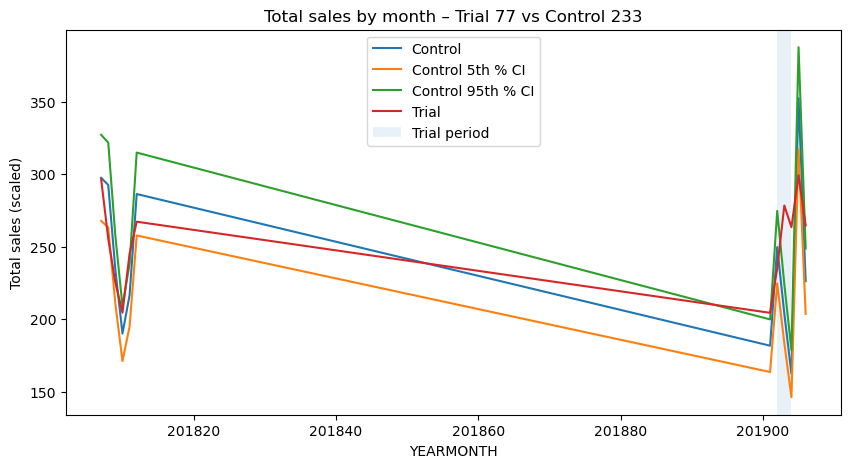

In [16]:
# 9. Plot total sales with confidence band


trial_store = 77
control_store_77 = control_map[trial_store]
summary = sales_summary_77
merged = summary['percentageDiff_table']
std_dev = summary['stdDev']

# Prepare base series (scaled control & trial)
df_plot = measure_over_time[
    measure_over_time['STORE_NBR'].isin([trial_store, control_store_77])
].copy()

# Scale control
df_plot.loc[df_plot['STORE_NBR'] == control_store_77, 'totSales_scaled'] = (
    df_plot.loc[df_plot['STORE_NBR'] == control_store_77, 'totSales']
    * summary['scaling_factor']
)
df_plot.loc[df_plot['STORE_NBR'] == trial_store, 'totSales_scaled'] = (
    df_plot.loc[df_plot['STORE_NBR'] == trial_store, 'totSales']
)

# Tag store type
df_plot['Store_type'] = np.where(
    df_plot['STORE_NBR'] == trial_store, 'Trial',
    np.where(df_plot['STORE_NBR'] == control_store_77, 'Control', 'Other')
)

# Aggregate mean per month & type (like R)
sales_plot = (
    df_plot
    .groupby(['YEARMONTH', 'Store_type'])['totSales_scaled']
    .mean()
    .reset_index()
)

# Add 5th / 95th band for control (approx using ±2*stdDev in percentage)
control_sales = sales_plot[sales_plot['Store_type'] == 'Control'].copy()
control_95 = control_sales.copy()
control_5  = control_sales.copy()

control_95['totSales_scaled'] = control_95['totSales_scaled'] * (1 + 2*std_dev)
control_5['totSales_scaled']  = control_5['totSales_scaled']  * (1 - 2*std_dev)

control_95['Store_type'] = 'Control 95th % CI'
control_5['Store_type']  = 'Control 5th % CI'

plot_all = pd.concat([sales_plot, control_95, control_5], ignore_index=True)

# Plot
for store_type, subset in plot_all.groupby('Store_type'):
    plt.plot(subset['YEARMONTH'], subset['totSales_scaled'], label=store_type)

plt.axvspan(201902, 201904, alpha=0.1, label='Trial period')  # highlight trial
plt.xlabel("YEARMONTH")
plt.ylabel("Total sales (scaled)")
plt.title(f"Total sales by month – Trial {trial_store} vs Control {control_store_77}")
plt.legend()
plt.show()


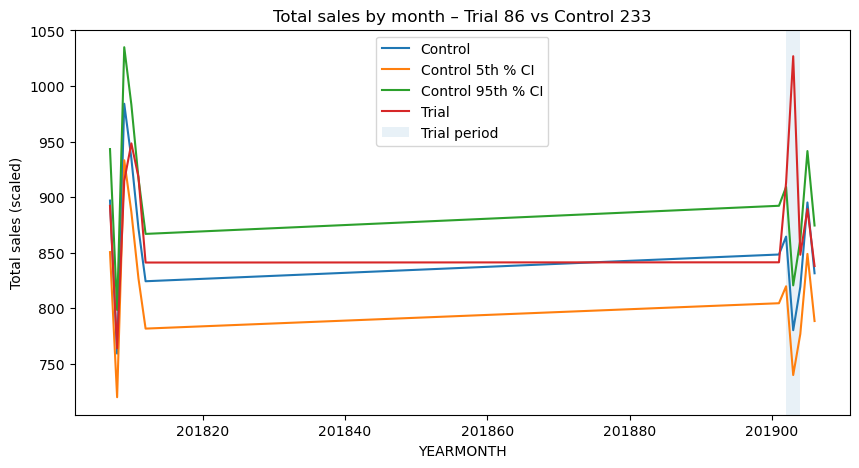

In [17]:
# 9. Plot total sales with confidence band


trial_store = 86
control_store_86 = control_map[trial_store]
summary = sales_summary_86
merged = summary['percentageDiff_table']
std_dev = summary['stdDev']

# Prepare base series (scaled control & trial)
df_plot = measure_over_time[
    measure_over_time['STORE_NBR'].isin([trial_store, control_store_86])
].copy()

# Scale control
df_plot.loc[df_plot['STORE_NBR'] == control_store_86, 'totSales_scaled'] = (
    df_plot.loc[df_plot['STORE_NBR'] == control_store_86, 'totSales']
    * summary['scaling_factor']
)
df_plot.loc[df_plot['STORE_NBR'] == trial_store, 'totSales_scaled'] = (
    df_plot.loc[df_plot['STORE_NBR'] == trial_store, 'totSales']
)

# Tag store type
df_plot['Store_type'] = np.where(
    df_plot['STORE_NBR'] == trial_store, 'Trial',
    np.where(df_plot['STORE_NBR'] == control_store_86, 'Control', 'Other')
)

# Aggregate mean per month & type (like R)
sales_plot = (
    df_plot
    .groupby(['YEARMONTH', 'Store_type'])['totSales_scaled']
    .mean()
    .reset_index()
)

# Add 5th / 95th band for control (approx using ±2*stdDev in percentage)
control_sales = sales_plot[sales_plot['Store_type'] == 'Control'].copy()
control_95 = control_sales.copy()
control_5  = control_sales.copy()

control_95['totSales_scaled'] = control_95['totSales_scaled'] * (1 + 2*std_dev)
control_5['totSales_scaled']  = control_5['totSales_scaled']  * (1 - 2*std_dev)

control_95['Store_type'] = 'Control 95th % CI'
control_5['Store_type']  = 'Control 5th % CI'

plot_all = pd.concat([sales_plot, control_95, control_5], ignore_index=True)

# Plot
for store_type, subset in plot_all.groupby('Store_type'):
    plt.plot(subset['YEARMONTH'], subset['totSales_scaled'], label=store_type)

plt.axvspan(201902, 201904, alpha=0.1, label='Trial period')  # highlight trial
plt.xlabel("YEARMONTH")
plt.ylabel("Total sales (scaled)")
plt.title(f"Total sales by month – Trial {trial_store} vs Control {control_store_77}")
plt.legend()
plt.show()


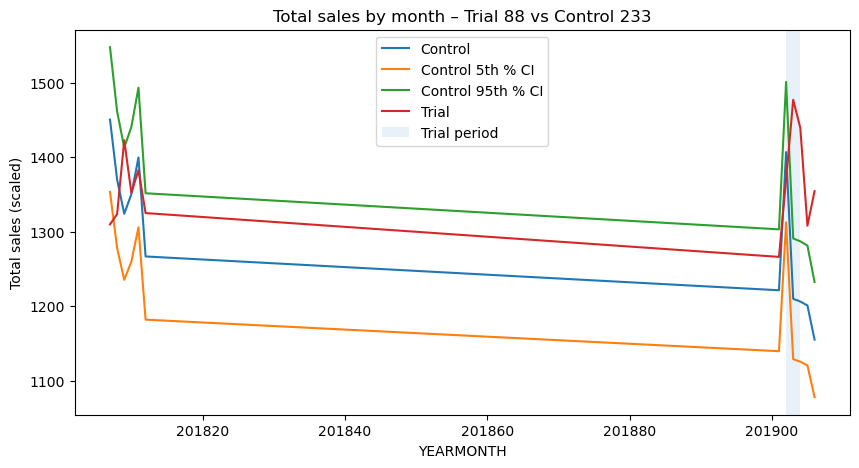

In [18]:
# 9. Plot total sales with confidence band


trial_store = 88
control_store_88 = control_map[trial_store]
summary = sales_summary_88
merged = summary['percentageDiff_table']
std_dev = summary['stdDev']

# Prepare base series (scaled control & trial)
df_plot = measure_over_time[
    measure_over_time['STORE_NBR'].isin([trial_store, control_store_88])
].copy()

# Scale control
df_plot.loc[df_plot['STORE_NBR'] == control_store_88, 'totSales_scaled'] = (
    df_plot.loc[df_plot['STORE_NBR'] == control_store_88, 'totSales']
    * summary['scaling_factor']
)
df_plot.loc[df_plot['STORE_NBR'] == trial_store, 'totSales_scaled'] = (
    df_plot.loc[df_plot['STORE_NBR'] == trial_store, 'totSales']
)

# Tag store type
df_plot['Store_type'] = np.where(
    df_plot['STORE_NBR'] == trial_store, 'Trial',
    np.where(df_plot['STORE_NBR'] == control_store_88, 'Control', 'Other')
)

# Aggregate mean per month & type (like R)
sales_plot = (
    df_plot
    .groupby(['YEARMONTH', 'Store_type'])['totSales_scaled']
    .mean()
    .reset_index()
)

# Add 5th / 95th band for control (approx using ±2*stdDev in percentage)
control_sales = sales_plot[sales_plot['Store_type'] == 'Control'].copy()
control_95 = control_sales.copy()
control_5  = control_sales.copy()

control_95['totSales_scaled'] = control_95['totSales_scaled'] * (1 + 2*std_dev)
control_5['totSales_scaled']  = control_5['totSales_scaled']  * (1 - 2*std_dev)

control_95['Store_type'] = 'Control 95th % CI'
control_5['Store_type']  = 'Control 5th % CI'

plot_all = pd.concat([sales_plot, control_95, control_5], ignore_index=True)

# Plot
for store_type, subset in plot_all.groupby('Store_type'):
    plt.plot(subset['YEARMONTH'], subset['totSales_scaled'], label=store_type)

plt.axvspan(201902, 201904, alpha=0.1, label='Trial period')  # highlight trial
plt.xlabel("YEARMONTH")
plt.ylabel("Total sales (scaled)")
plt.title(f"Total sales by month – Trial {trial_store} vs Control {control_store_77}")
plt.legend()
plt.show()
